#Sentiment Analysis Inference using Pretrained BERT Model

*italicized text*

In [1]:
!pip install -U transformers datasets evaluate accelerate
!pip install scikit-learn

  Using cached pyarrow-17.0.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-17.0.0-cp310-cp310-manylinux_2_28_x86_64.whl (39.9 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 6.0.1
    Uninstalling pyarrow-6.0.1:
      Successfully uninstalled pyarrow-6.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)

import evaluate
import numpy as np

In [3]:
BATCH_SIZE = 32
NUM_PROCS = 32
LR = 0.00005
EPOCHS = 2

In [4]:

train_dataset = load_dataset("imdb", split='train')
test_dataset = load_dataset("imdb", split='test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})


In [7]:
# Visualize a sample.
train_dataset[1]

{'text': '"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn\'t matter what one\'s political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn\'t true. I\'ve seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don\'t exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we\'re treated to the site of Vincent Gallo\'s throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, 

In [8]:


id2label = {
    0: "Negative",
    1: "Positive",
    2: "Neutral"
}
label2id = {
    "Negative": 0,
    "Positive": 1,
    "Neutral": 2
}


In [9]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Helper function for preprocessing.
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=BATCH_SIZE,
    num_proc=NUM_PROCS
)

tokenized_test = test_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=BATCH_SIZE,
    num_proc=NUM_PROCS
)

# Initialize data collator.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=32):   0%|          | 0/25000 [00:00<?, ? examples/s]

Map (num_proc=32):   0%|          | 0/25000 [00:00<?, ? examples/s]

In [10]:
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,  # Change num_labels to 3 to match the id2label mapping
    id2label=id2label,
    label2id=label2id
)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [13]:
training_args = TrainingArguments(
    output_dir="imdb_classification",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
history = trainer.train()


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,0.275200,0.176690,0.928960


# **the model has already reached 92% validation accuracy. This shows the efficacy of the Transformer architecture and the BERT pretrained model.**

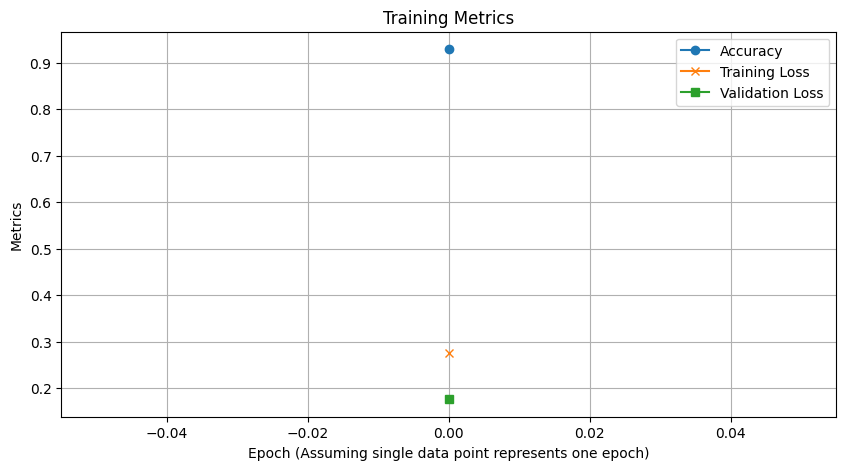

In [5]:

# Plotting
plt.figure(figsize=(10, 5))

plt.plot(accuracy, label='Accuracy', marker='o')
plt.plot(training_loss, label='Training Loss', marker='x')
plt.plot(valid_loss, label='Validation Loss', marker='s')

plt.xlabel('Epoch (Assuming single data point represents one epoch)')
plt.ylabel('Metrics')
plt.title('Training Metrics')
plt.legend()
plt.grid(True)
plt.show()
